## EDA of Dataset 2-2
### goals
- look for corrupt or useless data
- figure out general data format (image resolution/angle format)
- check label distribution
- come up with preprocessing strategy
- overfit model to small dataset to check feasibility of strategy

In [10]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
np.random.seed(1337)
%matplotlib inline
plt.style.use('ggplot')

In [11]:
path = "/media/austin/Storage/data-2.2"
center = os.path.join(path, "center", "*.jpg")
interpolated = os.path.join(path, "interpolated.csv")
steering = os.path.join(path, "steering.csv")

In [12]:
images = glob(center)
len(images)

28658

In [13]:
labels = pd.read_csv(interpolated)
cent = labels['filename'].apply(lambda x: "center" in x)
y = labels[cent][['angle']]
y.describe()

,angle
count,28658.000000
mean,-0.070827
std,1.205534
min,-8.278096
25%,-0.385718
50%,-0.019199
75%,0.055851
max,8.403760


### Looks like there are a lot of 0 valued steering angles in this set. Upon further investigation it seems that the first ~7000 images or so were shot facing a wall in a parking spot

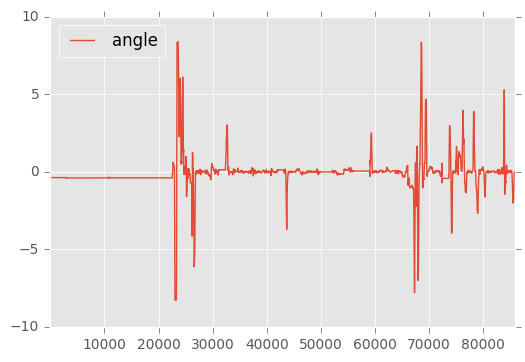

In [14]:
y.plot();

### Seems like we rarely steer, this could be a problem

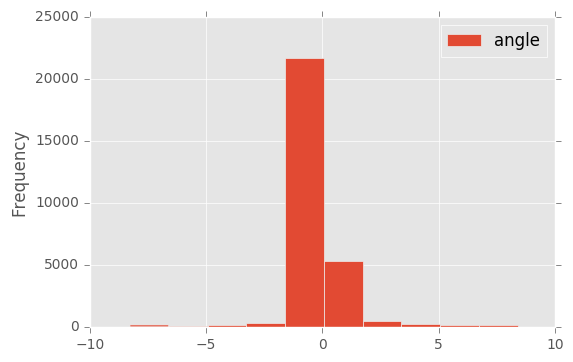

In [15]:
y.plot(kind='hist');

In [16]:
X = labels[cent]['filename']

In [17]:
def read_img(name, size=(224, 224)):
    img = os.path.join(path, name)
    img = cv2.imread(img)
    if size is not None:
        return cv2.resize(img, size)
    else:
        return img
    
def show_img(name, size=(224, 224)):
    img = read_img(name, size)
    plt.imshow(img)
    plt.grid('off')
    
def preprocess(img):
    img = img.astype('float32')
    img /= 255.0
    return img

In [18]:
# 7700 images of parking lot

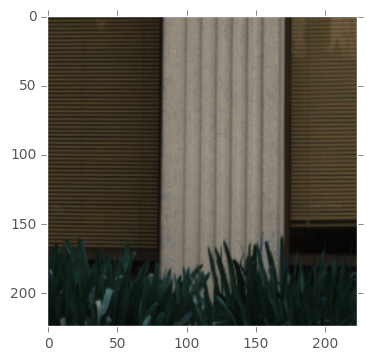

In [19]:
test = show_img(X.iloc[1])

In [20]:
data = labels[cent].iloc[7700:]

In [21]:
X.head(), y.head()

(2     center/1475520790430827155.jpg
 5     center/1475520790481041481.jpg
 8     center/1475520790530880584.jpg
 11    center/1475520790580930648.jpg
 14    center/1475520790630894119.jpg
 Name: filename, dtype: object,        angle
 2  -0.368264
 5  -0.368264
 8  -0.368264
 11 -0.368264
 14 -0.368264)

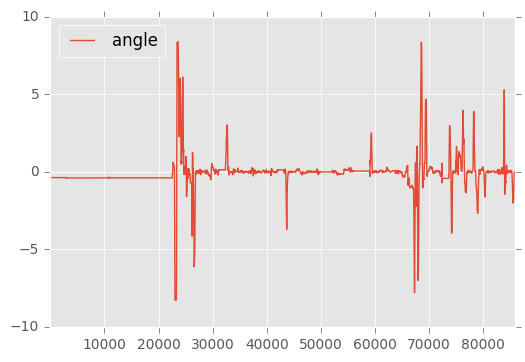

In [22]:
y.plot();

### The steering distribution is a little better without the parked sequence but this is still a very straight course.

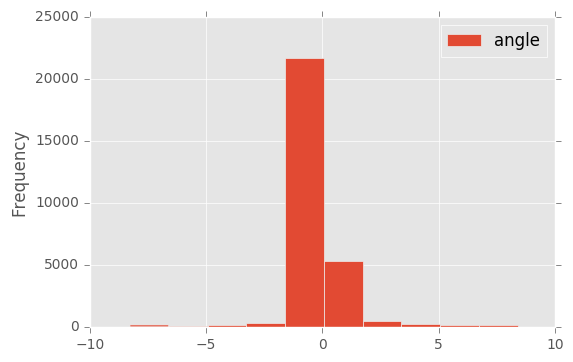

In [23]:
y.plot(kind='hist');

### Images are 480 x 640 x 3

In [24]:
x = read_img(X.iloc[0])

In [25]:
x.shape

(224, 224, 3)

In [26]:
dev = labels[cent].sample(32, random_state=1337)

In [27]:
X_dev = np.array(map(read_img, dev['filename']))
y_dev = dev['angle']

### lets try to overfit a small model on the dev set

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

Using TensorFlow backend.


In [29]:
model = Sequential()
model.add(Convolution2D(12, 3, 3, border_mode='same', input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(12, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [30]:
hist = model.fit(X_dev, y_dev, nb_epoch=20, batch_size=12)

Epoch 1/20
32/32 [==============================] - 0s - loss: 1228941.4048     
Epoch 2/20
32/32 [==============================] - 0s - loss: 69277.9844     
Epoch 3/20
32/32 [==============================] - 0s - loss: 14653.0519     
Epoch 4/20
32/32 [==============================] - 0s - loss: 298.0150     
Epoch 5/20
32/32 [==============================] - 0s - loss: 291.1596     
Epoch 6/20
32/32 [==============================] - 0s - loss: 32.4169     
Epoch 7/20
32/32 [==============================] - 0s - loss: 28.4350     
Epoch 8/20
32/32 [==============================] - 0s - loss: 19.6959     
Epoch 9/20
32/32 [==============================] - 0s - loss: 10.8842     
Epoch 10/20
32/32 [==============================] - 0s - loss: 5.7297     
Epoch 11/20
32/32 [==============================] - 0s - loss: 3.0962     
Epoch 12/20
32/32 [==============================] - 0s - loss: 1.8628     
Epoch 13/20
32/32 [==============================] - 0s - loss: 1.0635     

In [31]:
preds = model.predict(X_dev)

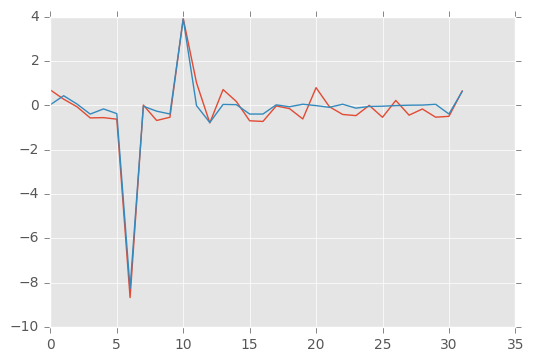

In [32]:
plt.plot(preds)
plt.plot(y_dev.values);

In [99]:
data = data[['filename', 'angle']].values

/home/austin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

### Try basic model on full 2-2 dataset

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    data[:,0], data[:,1], test_size=0.2, random_state=1337)

In [120]:
train = zip(X_train, y_train)
test = zip(X_test, y_test)
X_train.shape, X_test.shape

((16766,), (4192,))

In [121]:
def data_gen(data, y=True):
    while True:
        if y==True:
            for x, y in data:
                x = preprocess(read_img(x))
                x = np.expand_dims(x, axis=0)
                y = np.expand_dims(y, axis=0)
                yield x, y
        else:
            for x in data:
                x = preprocess(read_img(x))
                x = np.expand_dims(x, axis=0)
                yield x


In [122]:
train = data_gen(train)
val = data_gen(test)

In [123]:
hist = model.fit_generator(
    train, 
    samples_per_epoch=16766,
    nb_epoch=10,
    validation_data=val, nb_val_samples=4180)

Epoch 1/10
16757/16758 [============================>.] - ETA: 0s - loss: 1.8012

Exception in thread Thread-14:
Traceback (most recent call last):
  File "/home/austin/anaconda2/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/austin/anaconda2/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/home/austin/anaconda2/lib/python2.7/site-packages/keras/engine/training.py", line 433, in data_generator_task
    generator_output = next(generator)
StopIteration



Exception: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None